# Quant Conditional GAN
## Torch Verison

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

from preprocess.acf import *
from preprocess.gaussianize import *

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from model.torch_tcn import *
import os, sys
generator_path = f'/content/temporalCN/trained/'
if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"

device = torch.device(dev) 

### Importing and Visualizing Ticker Data from YFinance

In [3]:
#retrieve and store ticker data
def get_data(tickers):
    #storing ticker in dictionary for convenience 
    ticker_data ={}
    start_date = "2016-06-01"
    end_date = "2019-06-01"
    
    #iterating through ticker list
    for ticker in tickers:
        ticker_object = yf.Ticker(ticker)
        historical_data = ticker_object.history(start=start_date, end=end_date, interval="1d")
        ticker_data[str(ticker)] = historical_data['Close']
        
    return ticker_data

In [4]:
tickers = ['SPY', 'AAPL', 'TLT']
data = get_data(tickers)

In [5]:
#change type to df for extraction (and convenience) in a new cell so don't have to download data each time
data = pd.DataFrame(data=data)

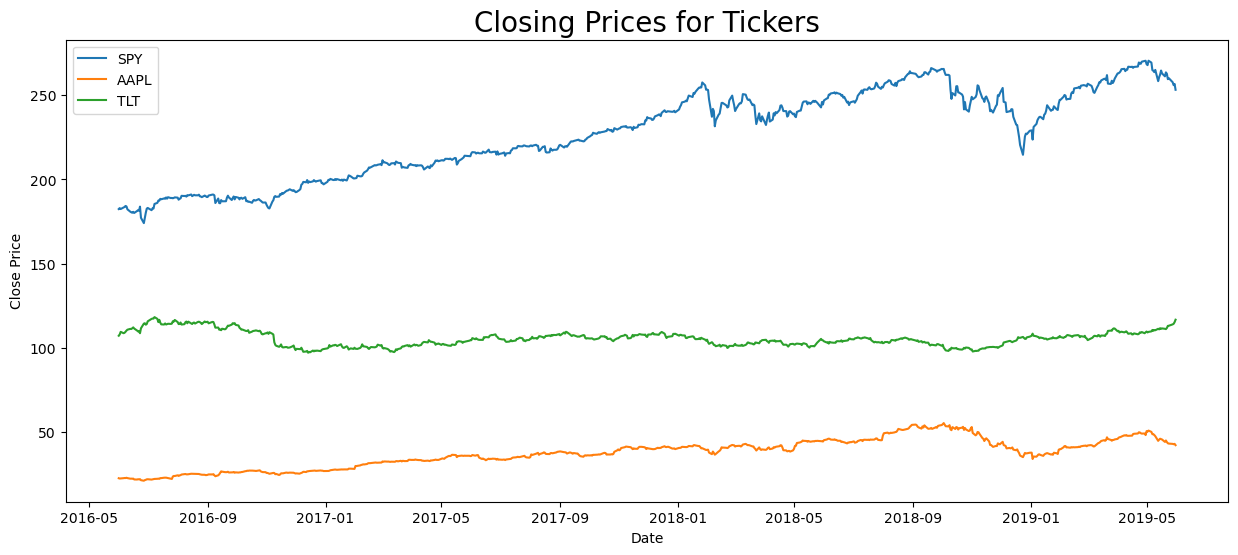

In [6]:

def dateparse(d):
    return pd.Timestamp(d)

fig = plt.figure(figsize=(15,6))
plt.title('Closing Prices for Tickers', fontsize=20)
for ticker in data.columns:
    plt.plot(data.index, data[ticker], label=ticker)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()
# confirm data loaded

### Preprocessing and visualizing data

In [7]:
class Loader32(Dataset):
    
    def __init__(self, data, length):
        assert len(data) >= length
        self.data = data
        self.length = length
    
    def __getitem__(self, idx):
        return torch.tensor(self.data[idx:idx+self.length]).reshape(-1, self.length).to(torch.float32)
        
    def __len__(self):
        return max(len(self.data)-self.length, 0)

returns = data.shift(1)/data - 1
log_returns = np.log(data/data.shift(1))[1:].to_numpy().reshape(-1, 3)
standardScaler1 = StandardScaler()
standardScaler2 = StandardScaler()
gaussianize = Gaussianize()
#try other scaler methods (minmax)
#remove second scaler

log_returns_preprocessed = standardScaler2.fit_transform(gaussianize.fit_transform(standardScaler1.fit_transform(log_returns)))
receptive_field_size = 127  # p. 17
data_size = log_returns.shape
print(data_size)


(754, 3)


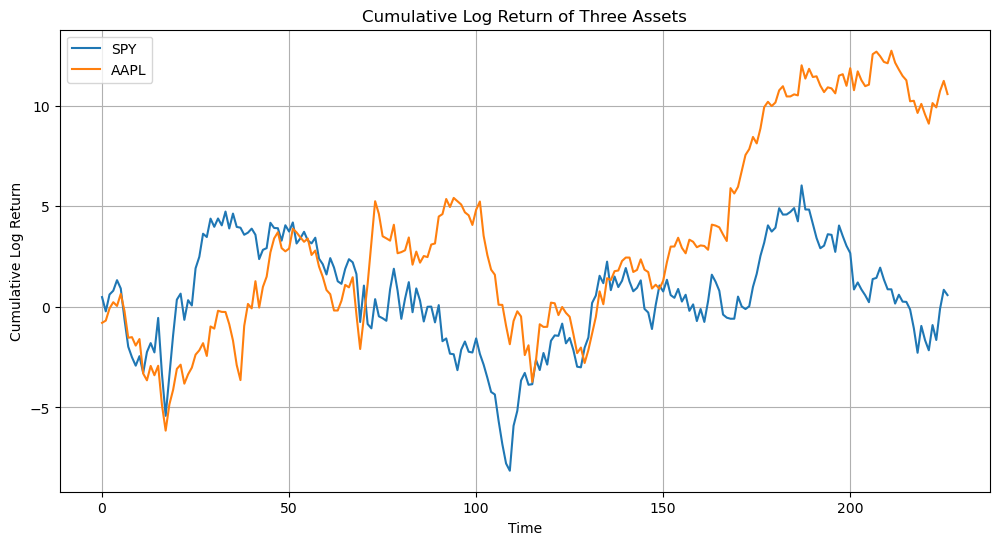

(754, 3)


In [119]:
cumulative_log_return_all = np.cumsum(log_returns_preprocessed, axis=0)
cumulative_log_return = cumulative_log_return_all[:]
plt.figure(figsize=(12, 6))
plt.plot(cumulative_log_return[:227, :2])
plt.title('Cumulative Log Return of Three Assets')
plt.xlabel('Time')
plt.ylabel('Cumulative Log Return')
plt.legend(['SPY', 'AAPL', 'TLT'])
plt.grid(True)
plt.show()
print(cumulative_log_return.shape)


## Parameters, Context

In [57]:
import importlib
from model import torch_tcn
importlib.reload(torch_tcn)
from model.torch_tcn import Generator, Discriminator
num_epochs = 200
nz = 3
batch_size = 100
seq_len = 127
clip= 0.01
lr = 0.000003

#conditional window
context_len = 100 #reduce context length
indx=101


#conditional
contextset = Loader32(log_returns_preprocessed,  context_len)
dataset = Loader32(log_returns_preprocessed, length=context_len)
generator = Generator().to("cpu")
total_len = context_len + seq_len
discriminator = Discriminator(seq_len=total_len)


if indx>= context_len:
    data = dataset[indx]
    context = contextset[indx].reshape(-1, 3, context_len)
    
    noise = torch.randn(batch_size, 3, seq_len, device=device)
    
    #append to noise with broadcasting
    context_broadcast = context.repeat(batch_size,1,1)
    cond_noise = torch.cat((context_broadcast, noise), axis=2)

    print(cond_noise.shape)
else:
    print("LengthError: Index must be greater than context length")



torch.Size([100, 3, 227])


c:\Users\juanp\anaconda3\envs\GAN_1\lib\site-packages\torch\nn\utils\weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


# Training


In [10]:
#Todo: wrap conditional statement around conditional noise to make sure idx>context length
import torch.optim as optim
from tqdm import tqdm
generator = Generator().to(device)

discloss = []
genloss = []

train = False

if train:
    context_len = 50
    discriminator = Discriminator((seq_len+context_len)).to(device)

    disc_optimizer = optim.RMSprop(discriminator.parameters(), lr=lr)
    gen_optimizer = optim.RMSprop(generator.parameters(), lr=lr)

    dataset = Loader32(log_returns_preprocessed, seq_len)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)

    #separate contextset which loads returns of context_len
    contextset = Loader32(log_returns_preprocessed,  context_len)

    t = tqdm(range(num_epochs))
    for epoch in t:
        for idx, data in enumerate(dataloader, context_len):
            discriminator.zero_grad()
            real = data.to(device)

            #context = tensor containing data[index - context_length: index] of length context_len hence why contextset is used
            context = contextset[idx-context_len].reshape(-1,3,context_len).to(torch.float32)
            
            #match on dim[0] so it can concatenate
            context_broadcast = context.repeat(batch_size,1,1)
            noise = torch.randn(batch_size, 3, seq_len, device=device) 

            #concatenate context and noise, context and real
            cond_noise = torch.cat((context_broadcast, noise), axis=2)
            realandcontext = torch.cat((context, real), axis=2)

            fake = generator(cond_noise).detach()
            disc_loss = -torch.mean(discriminator(realandcontext)) + torch.mean(discriminator(fake))
            disc_loss.backward()
            disc_optimizer.step()
            discloss.append(disc_loss.item())

            for dp in discriminator.parameters():
                dp.data.clamp_(-clip, clip)
    
            if idx % 5 == 0: #2-5
                generator.zero_grad()
                gen_loss = -torch.mean(discriminator(generator(cond_noise)))    
                gen_loss.backward()
                gen_optimizer.step() 
                genloss.append(gen_loss.item())           
        t.set_description('Discriminator Loss: %.8f Generator Loss: %.8f' % (disc_loss.item(), gen_loss.item()))
            
    # Save
    torch.save(generator, f'SPYAAPLTLT/conditional_{num_epochs}_epochs_v1.0.pth')

### Loss Diagrams

In [146]:
plt.plot(discloss[5:])
plt.show()


### Generating Synthetic Samples

In [121]:

generator = torch.load("SPYAAPLTLT/conditional_1200_epochs_v1.0.pth")
y = generator(cond_noise).cpu().detach().squeeze()


(100, 3, 227)


In [ ]:
#chatgpt made this cell i dont know what it means

# Reshape y to (batch_size * length, 3) before applying scaling
y_reshaped = y.reshape(-1, 3)

# Apply the transformations
y_reshaped = (y_reshaped - y_reshaped.mean(axis=0)) / y_reshaped.std(axis=0)
y_reshaped = standardScaler2.inverse_transform(y_reshaped)
y_reshaped = np.array([gaussianize.inverse_transform(x.reshape(-1, 1)).flatten() for x in y_reshaped.T]).T
y_reshaped = standardScaler1.inverse_transform(y_reshaped)

# Reshape back to (batch_size, 3, length)
y = y_reshaped.reshape(3, -1, y.shape[-1]).transpose(1, 0, 2)

print(y.shape)
xxx=0




## Results and visualizing stylized facts

In [135]:
#batch 2
lengthsize = 227
normalizedsynth = torch.nn.functional.normalize(torch.from_numpy(y[0,:2, :])).reshape(-1,y.shape[2])
spyreturns = normalizedsynth[0,:].numpy()
aaplreturns = normalizedsynth[1, :].numpy()

distances = np.sqrt(spyreturns**2 + aaplreturns**2)
mask = distances <= 0.08
spyreturnsf = spyreturns[mask]
aaplreturnsf = aaplreturns[mask]

#minmax normalization
spyreturnsfn = (spyreturnsf - np.min(spyreturnsf)) / (np.max(spyreturnsf) - np.min(spyreturnsf)) * 2 - 1
aaplreturnsfn = (aaplreturnsf - np.min(aaplreturnsf)) / (np.max(aaplreturnsf) - np.min(aaplreturnsf)) * 2 - 1


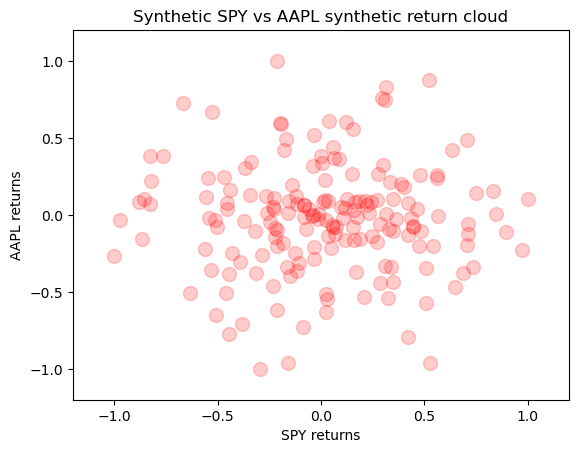

<Figure size 1600x900 with 0 Axes>

In [136]:
#Graph
plt.scatter(spyreturnsfn, aaplreturnsfn, alpha=0.2, s=100, c="red")
lim=1.2
plt.title("Synthetic SPY vs AAPL synthetic return cloud")
plt.xlabel("SPY returns")
plt.ylabel("AAPL returns")
plt.xlim([-lim, lim])
plt.ylim([-lim, lim])
plt.figure(figsize=(16,9))
plt.show()


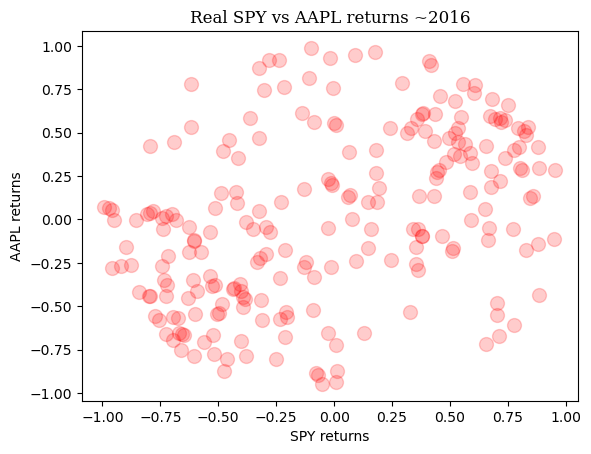

<Figure size 1600x900 with 0 Axes>

In [109]:
logreturnstensor = torch.from_numpy(log_returns_preprocessed)
log_returns_preprocessednorm = torch.nn.functional.normalize(logreturnstensor)
plt.scatter(log_returns_preprocessednorm[:227, 0], log_returns_preprocessednorm[:227, 1], alpha=0.2, s=100, c="red")
plt.title("Real SPY vs AAPL returns ~2016", fontdict={'family': 'Serif', 'size': 12})
plt.xlabel("SPY returns")
plt.ylabel("AAPL returns")
plt.figure(figsize=(16,9))

plt.show()


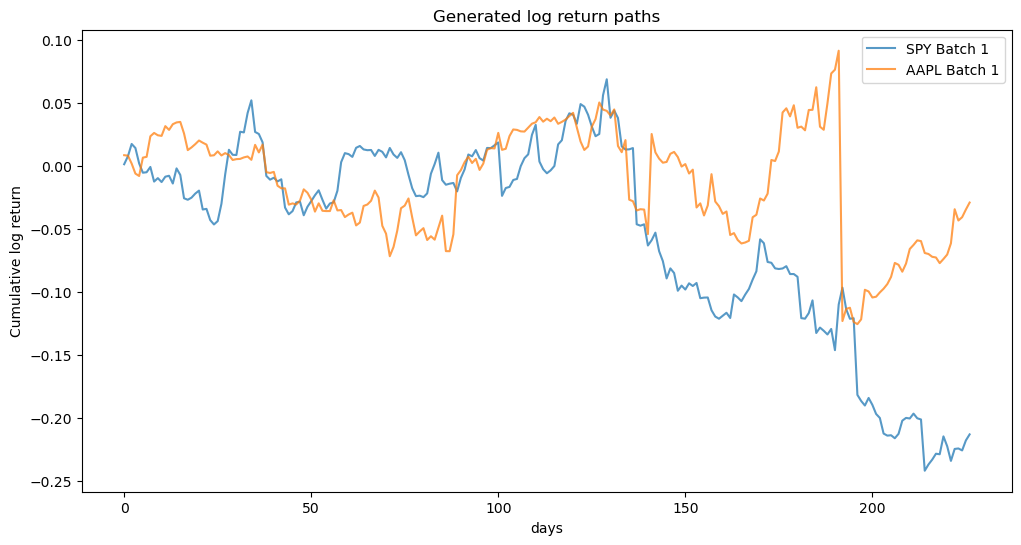

In [128]:
xxx=0
fig, ax = plt.subplots(figsize=(12, 6))

# Loop through the first 3 batches
for i in range(xxx,xxx+1):
    for j in range(2):  # Loop through each asset
        if j == 0:
            asset = "SPY"
        elif j==1:
            asset = "AAPL"
        # elif j==2:
        #     asset = "TLT"     
        ax.plot(np.cumsum(y[i, j, :]), alpha=0.75, label=f'{asset} Batch {i + 1}')

ax.set_title('Generated log return paths')
ax.set_xlabel('days')
ax.set_ylabel('Cumulative log return')
ax.legend()

plt.show()
# xxx+=1

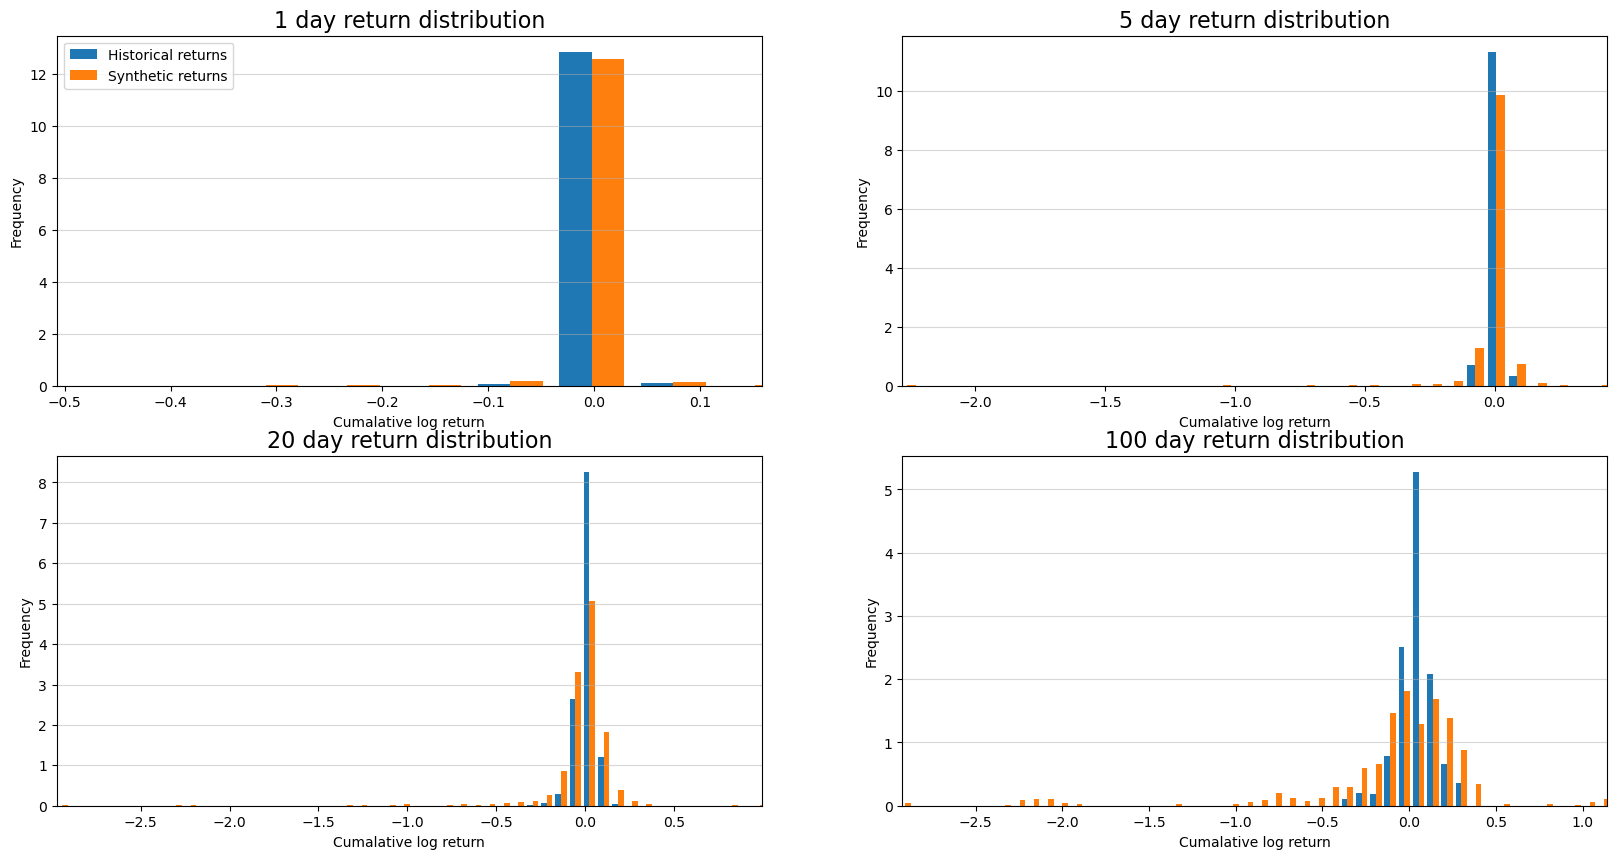

In [100]:
n_bins = 50
windows = [1, 5, 20, 100]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))


for i in range(len(windows)):
    row = min(max(0, i-1), 1)
    col = i % 2
    real_dist = rolling_window(log_returns, windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    fake_dist = rolling_window(y.T, windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    axs[row, col].hist(np.array([real_dist, fake_dist], dtype='object'), bins=50, density=True)
    axs[row,col].set_xlim(*np.quantile(fake_dist, [0.001, .999]))
    
    axs[row,col].set_title('{} day return distribution'.format(windows[i]), size=16)
    axs[row,col].yaxis.grid(True, alpha=0.5)
    axs[row,col].set_xlabel('Cumalative log return')
    axs[row,col].set_ylabel('Frequency')

axs[0,0].legend(['Historical returns', 'Synthetic returns'])


[Text(0.5, 0, 'Lag (number of days'),
 Text(0.5, 0, 'Lag (number of days'),
 Text(0.5, 0, 'Lag (number of days'),
 Text(0.5, 0, 'Lag (number of days')]

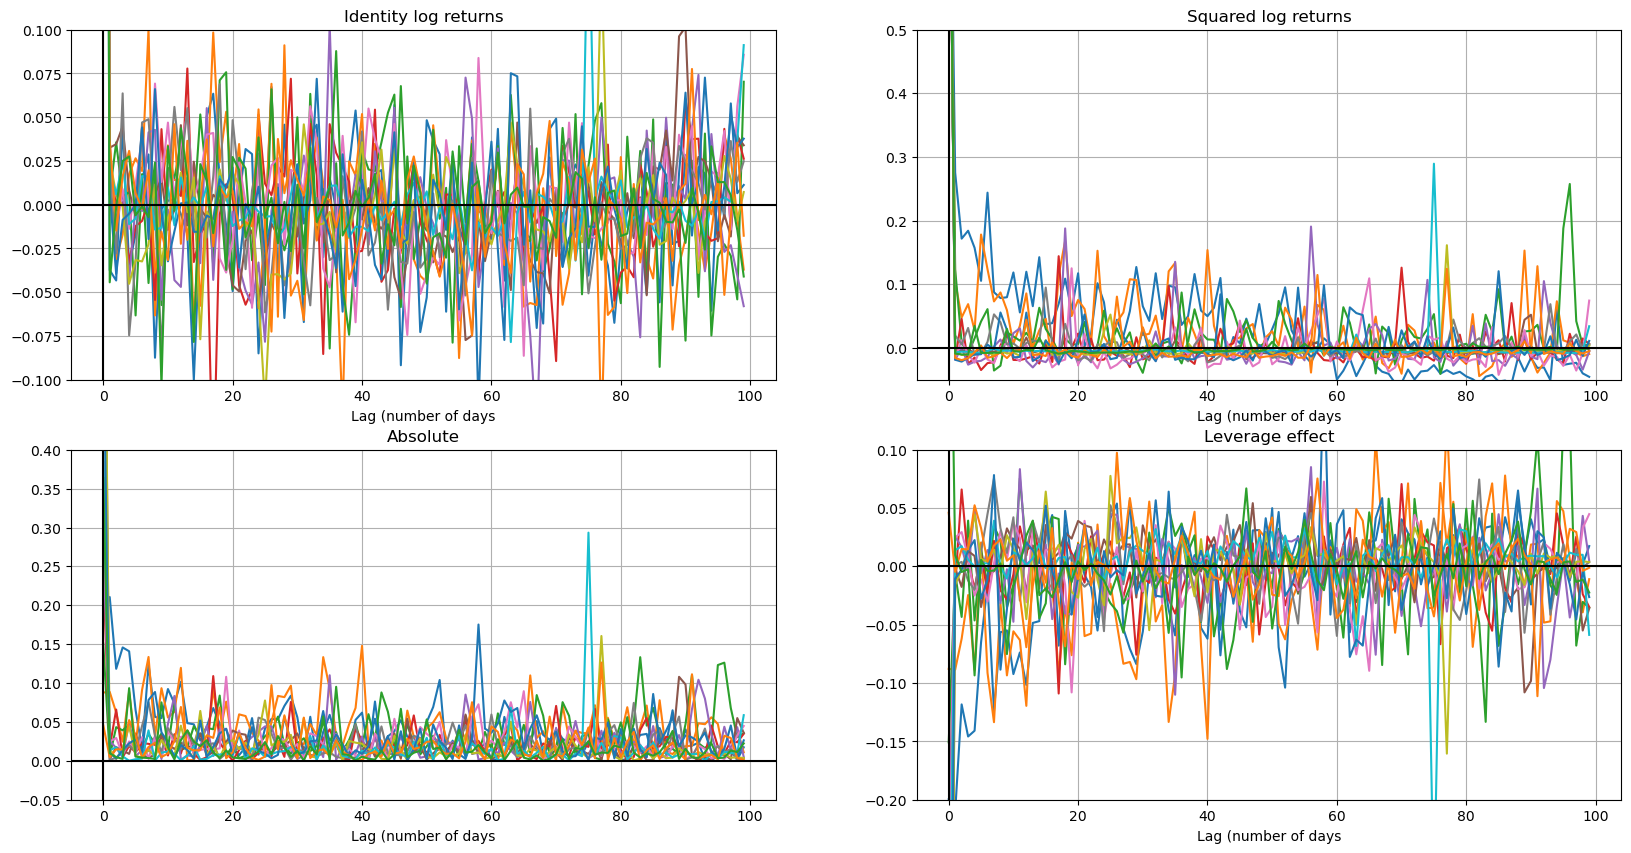

In [97]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))

axs[0,0].plot(acf(log_returns, 100))
axs[0,0].plot(acf(y.T, 100).mean(axis=1))
axs[0,0].set_ylim(-0.1, 0.1)
axs[0,0].set_title('Identity log returns')
axs[0,1].plot(acf(log_returns**2, 100))
axs[0,1].set_ylim(-0.05, 0.5)
axs[0,1].plot(acf(y.T**2, 100).mean(axis=1))
axs[0,1].set_title('Squared log returns')
axs[1,0].plot(abs(acf(log_returns, 100, le=True)))
axs[1,0].plot(abs(acf(y.T, 100, le=True).mean(axis=1)))
axs[1,0].set_ylim(-0.05, 0.4)
axs[1,0].set_title('Absolute')
axs[1,1].plot(acf(log_returns, 100, le=True))
axs[1,1].plot(acf(y.T, 100, le=True).mean(axis=1))
axs[1,1].set_ylim(-0.2, 0.1)
axs[1,1].set_title('Leverage effect')


for ax in axs.flat: 
  ax.grid(True)
  ax.axhline(y=0, color='k')
  ax.axvline(x=0, color='k')
plt.setp(axs, xlabel='Lag (number of days')



# Earth Mover Distance